In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy import sparse 
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
from py_pcha import PCHA

In [2]:
# adata_raw = sc.read('../../data/cheng21_cell_scrna/reorganized/P28NR_L23_forPCHA.h5ad')

# # use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
# genes_l23 = df['gene'].values
# adata = adata_raw[:, genes_l23]
# adata.write('../../data/cheng21_cell_scrna/reorganized/P28NR_L23_forPCHA_n286genes.h5ad')

In [3]:
# # Use P28 ordering
# f = '../../results/gene_ptime_P28_L23_Mar27.tsv'
# gpt = pd.read_csv(f)
# gpt = gpt['gene_ptime'].values
# gptidx = np.argsort(gpt)

In [4]:
def norm(x, depths):
    """
    Arguments: 
        x - cell by gene count matrix
        depths - sequencing depth per cell
        
    Output:
        xn - normalized count matrix

    This function takes raw counts as the input, and does the following steps sequencially.
         1. size normalization (CP10k) 
         2. log1p normalization (base 2 - log2(1+CP10k))
         3. zscore per gene  
    """

    xn = x/depths.reshape(-1,1)*1e4
    xn = np.log2(1+xn)
    xn = zscore(xn, axis=0)

    if np.any(np.isnan(xn)):
        print('Warning: the normalized matrix contains nan values. Check input.')

    return xn

In [5]:
def proj(x_norm, ndim, method='PCA'):
    """
    Arguments: 
        x_norm - normalized cell by gene feature matrix
        ndim   - number of dimensions

    Output:
        x_proj - a low-dimensional representation of `x_norm` 

    Here we only implemented PCA - a common projection method widely used, including by
    Adler et al. 2019 and Xie et al. 2024 for the Achetypal Analysis of scRNA-seq data.

    In principle, one can also choose to use other projection methods as needed.
    """

    if method == 'PCA':
        x_proj = PCA(n_components=ndim).fit_transform(x_norm)
    else:
        raise ValueError('methods other than PCA are not implemented...')

    return x_proj


In [6]:
def pcha(X, noc=3, delta=0, **kwargs):
    """
    """
    XC, S, C, SSE, varexpl = PCHA(X, noc=noc, delta=delta, **kwargs)
    XC = np.array(XC)
    XC = XC[:,np.argsort(XC[0])] # assign an order according to x-axis 
    return XC 

In [7]:
def downsamp(x, which='cell', p=0.8, seed=None):
    """
    Arguments:
        x - cell by gene matrix
        which - downsample cells (rows) or genes (columns)
        p - fraction of cells/genes to keep - should be a value between ~ [0,1]
    """
    n0, n1 = x.shape
    
    rng = np.random.default_rng(seed=seed)
    
    if which in [0, 'cell', 'row']:
        return x[rng.random(n0)<p, :]
    elif which in [1, 'gene', 'col', 'column']:
        return x[:, rng.random(n1)<p]
    else:
        raise ValueError('choose from cell or gene')

In [8]:
def shuffle_rows_per_col(x, seed=None):
    """
    Arguments:
       x - cell by gene matrix
       seed - a random seed for reproducibility
    
    shuffles entries across rows (cells) independently for each col (gene)
    """
    rng = np.random.default_rng(seed=seed)
    x_shuff = rng.permuted(x, axis=0)
    return x_shuff

In [9]:
def plot_archetype(ax, aa, fmt='--o', color='k', **kwargs):
    """
    """
    ax.plot(aa[0].tolist()+[aa[0,0]], aa[1].tolist()+[aa[1,0]], fmt, color=color, **kwargs)

In [10]:
def get_t_ratio(xp, aa):
    """
    Arguments:
     xp -- projected matrix (cell by 2)
     aa -- inferred archetypes (2 by noc)
     note that this function only works for 2-dimensional space only
     
    Return: 
     t-ratio - ratio of areas (convex hull vs PCH)
     
    """
    assert xp.shape[1] == aa.shape[0] == 2
    
    ch_area  = ConvexHull(xp).volume
   
    x = aa[0]
    y = aa[1]
    pch_area = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

    return ch_area/pch_area 

In [11]:
class SingleCellArchetype():
    """
    """
    def __init__(self, x, depths, types):
        """
        Arguments: 
            x - cell by gene count matrix
            depths - sequencing depth per cell
            types  - cell type labels per cell
        
        Initiate the SingleCellArchetype object

        """
        
        # input
        self.x = x
        self.depths = depths
        self.types = types
        
        # cell type label
        types_idx, types_lbl = pd.factorize(types, sort=True)
        
        self.types_idx = types_idx
        self.types_lbl = types_lbl 
        
        # normalize
        self.xn = norm(self.x, self.depths)
        
        # feature matrix 
        self.xf = None 
        return 
        
    def setup_feature_matrix(self, method='data'):
        """
        """
        if method == 'data': 
            self.xf = self.xn
            print('use data')
            return  
        
        elif method == 'gshuff':
            # shuffle gene expression globally across all cells
            self.xf = shuffle_rows_per_col(self.xn)
            print('use shuffled data')
            return
            
        elif method == 'tshuff':
            # shuff each gene across cells independently - internally for each type A,B,C
            xn = self.xn
            xn_tshuff = xn.copy()
            
            types_lbl = self.types_lbl
            types_idx = self.types_idx
            for i in range(len(types_lbl)):
                xn_tshuff[types_idx==i] = shuffle_rows_per_col(xn[types_idx==i])
            self.xf = xn_tshuff
            print('use per-type shuffled data')
            return
        else:
            raise ValueError('choose from (data, gshuff, tshuff)')
    
    def proj_and_pcha(self, ndim, noc, **kwargs):
        """
        """
        xp = proj(self.xf, ndim)
        aa = pcha(xp.T, noc=noc, **kwargs)
        
        self.xp = xp
        self.aa = aa
        return (xp, aa)
        
    def downsamp_proj_pcha(self, ndim, noc, nrepeats=10, which='cell', p=0.8, **kwargs): 
        """
        """
        aa_dsamps = []
        for i in range(nrepeats):
            xn_dsamp = downsamp(self.xf, which=which, p=p)
            xp_dsamp = proj(xn_dsamp, ndim)
            aa_dsamp = pcha(xp_dsamp.T, noc=noc, **kwargs)
            aa_dsamps.append(aa_dsamp)
            
        return aa_dsamps
    
    def t_ratio_test(self, ndim, noc, nrepeats=10, **kwargs): 
        """
        this only work for 2-dimensional space for now
        """
        assert ndim == 2
        
        self.setup_feature_matrix(method='data')
        xp, aa = self.proj_and_pcha(ndim, noc)
        t_ratio = get_t_ratio(xp, aa)
        
        t_ratios_shuff = []
        for i in range(nrepeats):
            self.setup_feature_matrix(method='gshuff')
            xp_shuff, aa_shuff = self.proj_and_pcha(ndim, noc)
            t_ratio_shuff = get_t_ratio(xp_shuff, aa_shuff)
            t_ratios_shuff.append(t_ratio_shuff)
            
        pvalue = (np.sum(t_ratio > t_ratios_shuff)+1)/nrepeats
        
        return t_ratio, t_ratios_shuff, pvalue

In [12]:
adata = sc.read('../../data/cheng21_cell_scrna/reorganized/P28NR_L23_forPCHA_n286genes.h5ad')
adata

AnnData object with n_obs × n_vars = 4044 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'
    layers: 'lognorm', 'norm'

In [13]:
# set up
x = np.array(adata.X.todense())
depths = adata.obs['n_counts'].values
types = adata.obs['Type'].values

sca = SingleCellArchetype(x, depths, types)

# do and shuffle

In [14]:
ndim = 2
noc = 3
sca.setup_feature_matrix(method='data')
xp, aa = sca.proj_and_pcha(ndim, noc)

nrepeats = 3
p = 0.8
aa_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use data


In [15]:
# gshuff
sca.setup_feature_matrix(method='gshuff')
xp_gshuff, aa_gshuff = sca.proj_and_pcha(ndim, noc)
aa_gshuff_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use shuffled data


In [16]:
# tshuff 
sca.setup_feature_matrix(method='tshuff')
xp_tshuff, aa_tshuff = sca.proj_and_pcha(ndim, noc)
aa_tshuff_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use per-type shuffled data


# plot

In [17]:
types_colorvec = np.char.add('C', sca.types_idx.astype(str))

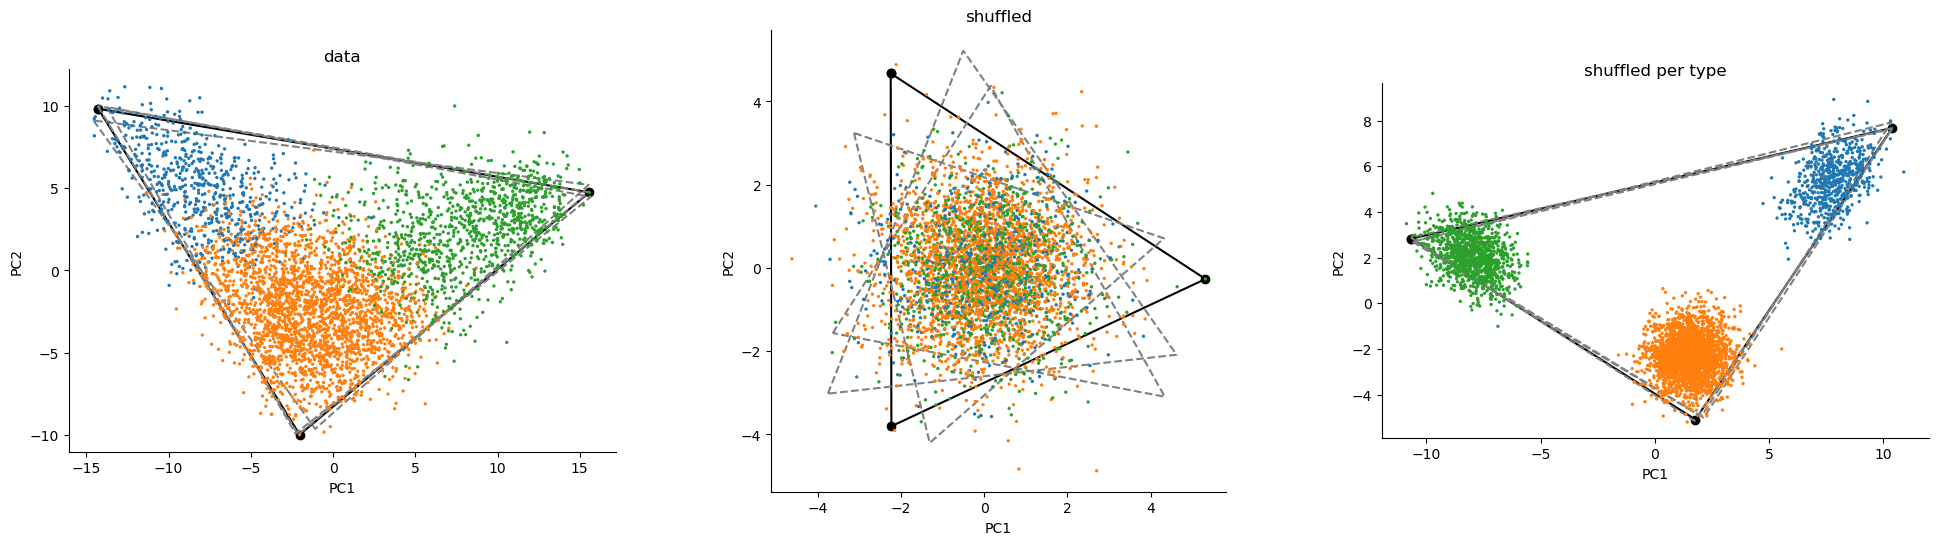

In [18]:
# plot
fig, axs = plt.subplots(1,3,figsize=(8*3,6))
ax = axs[0]
ax.scatter(xp[:,0], xp[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa, fmt='-o', color='k', zorder=0)
for i in range(nrepeats):
    plot_archetype(ax, aa_dsamps[i], fmt='--', color='gray', zorder=0)
ax.set_title('data')
    
ax = axs[1]
ax.set_title('shuffled')
ax.scatter(xp_gshuff[:,0], xp_gshuff[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa_gshuff, fmt='-o', color='k', zorder=0)
for i in range(nrepeats):
    plot_archetype(ax, aa_gshuff_dsamps[i], fmt='--', color='gray', zorder=0)

ax = axs[2]
ax.set_title('shuffled per type')
ax.scatter(xp_tshuff[:,0], xp_tshuff[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa_tshuff, fmt='-o', color='k', zorder=0)
for i in range(nrepeats):
    plot_archetype(ax, aa_tshuff_dsamps[i], fmt='--', color='gray', zorder=0)

for i in range(3):
    ax = axs[i]
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_aspect('equal')
    sns.despine(ax=ax)
    ax.grid(False)
    
plt.show()

# quantify t-ratio 

- for 2-dimensional data only

In [19]:
t_ratio, t_ratio_shuffs, pval = sca.t_ratio_test(ndim, noc, nrepeats=20)
print(f'p-value: {pval}')

use data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
p-value: 0.05


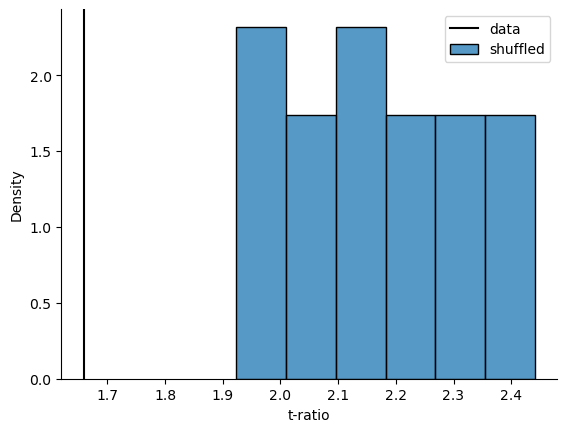

In [20]:
fig, ax = plt.subplots()
ax.axvline(t_ratio, color='k', label='data')
sns.histplot(t_ratio_shuffs, ax=ax, stat='density', label='shuffled')
ax.set_xlabel('t-ratio')
ax.legend()
sns.despine(ax=ax)
plt.show()

# quantify stability

In [21]:
from sklearn.metrics import pairwise_distances

In [22]:
def get_relative_variation(aa_list):
    """
    """
    
    aa_avg = np.mean(aa_list, axis=0).T
    ref = np.mean(pairwise_distances(aa_avg))

    aa_std = np.std(aa_list, axis=0).T
    epsilon = np.mean(np.sqrt(np.sum(np.power(aa_std,2), axis=1)))
    
    return epsilon/ref

In [23]:
var_data   = get_relative_variation(aa_dsamps)
var_gshuff = get_relative_variation(aa_gshuff_dsamps)

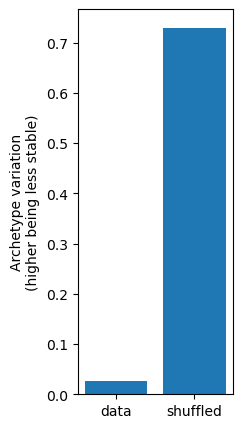

In [25]:
fig, ax = plt.subplots(figsize=(2,5))
ax.bar(np.arange(2), [var_data, var_gshuff])
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['data', 'shuffled'])
ax.set_ylabel('Archetype variation\n(higher being less stable)')
plt.show()